In [68]:
import kagglehub

path = kagglehub.dataset_download("meherunnesashraboni/multi-label-image-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mzums/.cache/kagglehub/datasets/meherunnesashraboni/multi-label-image-classification-dataset/versions/7


In [69]:
from fastai.vision.all import *

In [70]:
path = "/home/mzums/.cache/kagglehub/datasets/meherunnesashraboni/multi-label-image-classification-dataset/versions/7/multilabel_modified/"

In [71]:
df = pd.read_csv(f"{path}multilabel_classification_7.csv")
df.tail()

,Image_Name,Classes
7938,image7839.jpg,ektara flutes tabla harmonium
7939,image7840.jpg,ektara flutes tabla harmonium
7940,image7841.jpg,ektara flutes tabla harmonium
7941,image7842.jpg,ektara flutes tabla harmonium
7942,image7843.jpg,ektara flutes tabla harmonium


In [72]:
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock
from pathlib import Path
import pandas as pd

path = Path("/home/mzums/.cache/kagglehub/datasets/meherunnesashraboni/multi-label-image-classification-dataset/versions/7/multilabel_modified/")
images_path = path / "images"

df = pd.read_csv(path / "multilabel_classification_7.csv")

def get_x(r): 
    return images_path / r['Image_Name']

def get_y(r): 
    return [r['Classes'].strip()]

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    item_tfms=Resize(224),
    splitter=None
)


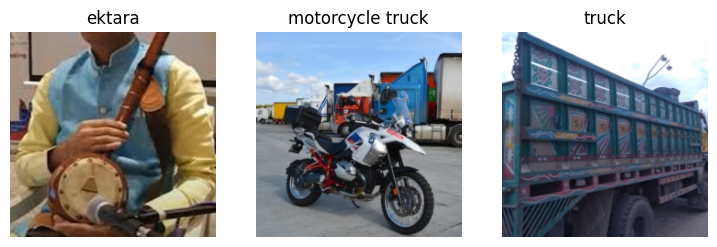

In [73]:
dls = dblock.dataloaders(df)

# Sprawdzenie wyników
dls.show_batch(nrows=1, ncols=3)

In [74]:
dsets = dblock.datasets(df)
dsets.train[0]


(PILImage mode=RGB size=425x450,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 1.]))

In [75]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]


(#1) ['truck']

In [76]:
dls = dblock.dataloaders(df)


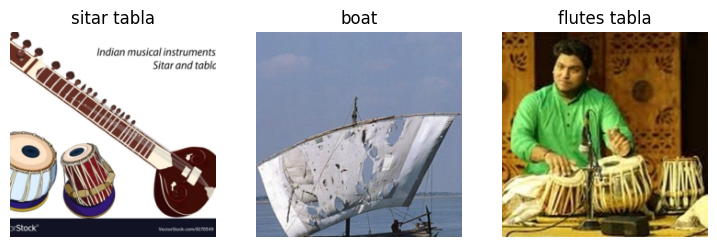

In [77]:
dls.show_batch(nrows=1, ncols=3)

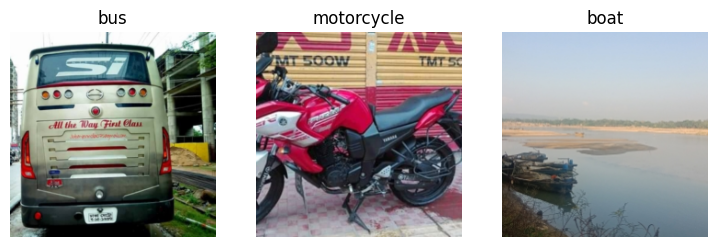

In [78]:
from fastai.vision.all import *

path = Path("/home/mzums/.cache/kagglehub/datasets/meherunnesashraboni/multi-label-image-classification-dataset/versions/7/multilabel_modified/")
images_path = path / "images"

df = pd.read_csv(path / "multilabel_classification_7.csv")
df.columns = [col.strip() for col in df.columns]

def get_x(r): 
    return images_path / r['Image_Name']

def get_y(r): 
    return r['Classes'].split()

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    item_tfms=Resize(224),
    splitter=RandomSplitter(valid_pct=0.2)
)

dls = dblock.dataloaders(df)

dls.show_batch(nrows=1, ncols=3)


In [79]:
dblock.summary(df)

Setting-up type transforms pipelines
0        image1.jpg                             bus 
1        image2.jpg                            sitar
2        image3.jpg                           flutes
3        image4.jpg                             bus 
4        image5.jpg                              bus
...             ...                              ...
7938  image7839.jpg    ektara flutes tabla harmonium
7939  image7840.jpg    ektara flutes tabla harmonium
7940  image7841.jpg    ektara flutes tabla harmonium
7941  image7842.jpg    ektara flutes tabla harmonium
7942  image7843.jpg    ektara flutes tabla harmonium

[7943 rows x 2 columns]
Found 7943 items
2 datasets of sizes 6355,1588
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      Image_Name    image6924.jpg
Classes               truck

In [80]:
learn = vision_learner(dls, resnet18)

In [81]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 10])

In [82]:
activs[0]

TensorImage([-3.3461, -0.6441,  1.0620,  4.2275,  0.5100,  0.9542, -0.6945,
              0.7726, -2.0504,  0.8979], grad_fn=<AliasBackward0>)

In [83]:
print(activs.shape)
print(y.shape)

torch.Size([64, 10])
torch.Size([64, 10])


In [84]:
loss_func = nn.BCEWithLogitsLoss()

activs = activs.float()
y = y.float().as_subclass(torch.Tensor)

loss = loss_func(activs, y)
print(loss)


TensorImage(1.0944, grad_fn=<AliasBackward0>)


In [85]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss


TensorImage(1.0944, grad_fn=<AliasBackward0>)

In [86]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh) == targ.bool()).float().mean()

In [87]:
learn = vision_learner(dls, resnet50, metrics = partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.583714,0.317006,0.568451,00:30
1,0.294629,0.081452,0.948678,00:29
2,0.097531,0.025131,0.991310,00:29
3,0.044152,0.022517,0.991310,00:29


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.027510,0.020092,0.991688,00:35
1,0.023561,0.020154,0.992632,00:35
2,0.015582,0.017098,0.993514,00:35


In [88]:
learn.metrics = partial(accuracy_multi, thresh=0.5)
learn.validate()

(#2) [0.017098426818847656,0.9938287138938904]

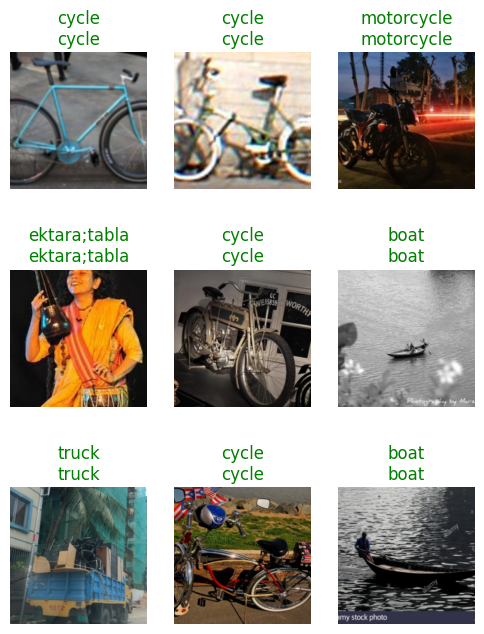

In [89]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))